

1.   회귀
  - 값을 직접 예측
  - 신경망의 출력을 그대로 사용
2.   분류
  - 어떤 범주에 들어가는지
  - 신경망의 출력을 확률 분포로 바꾸면
  - 시그모이드(이진), 소프트맥스(다중)






In [30]:
import matplotlib.pyplot as plt
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

In [31]:
# 데이터 가져오기
training_data = MNIST(root='./', train=True, download=True, transform=ToTensor() )
test_data = MNIST(root='./', train=False, download=True, transform=ToTensor() )

In [32]:
len(training_data),training_data.data.shape

(60000, torch.Size([60000, 28, 28]))

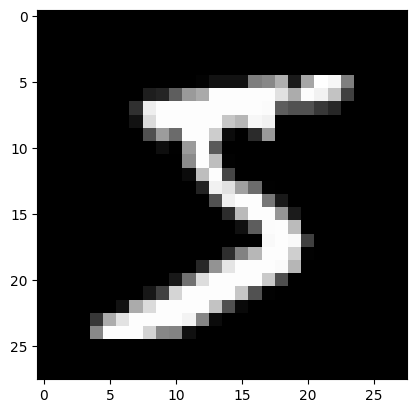

In [33]:
plt.imshow(training_data.data[0],cmap='gray')

In [34]:
# 데이터 로더 정의
from torch.utils.data.dataloader import DataLoader
train_loader = DataLoader(training_data,batch_size=32,shuffle=True)
# 평가용은 데이터를 섞을 필요가 없음
test_loader = DataLoader(test_data,batch_size=32,shuffle=False)

In [35]:
next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [36]:

for i in train_loader:
  print(i[0].shape, i[1].shape)
  break


torch.Size([32, 1, 28, 28]) torch.Size([32])


In [37]:
# 학습모델 만들고 학습하기
# 모델정의 ->학습 ->손실계산 ->오차역전파 및 최적화(적용) ->반복 ->종료
import torch
import torch.nn as nn
from torch.optim.adam import Adam

In [38]:
28*28

784

In [ ]:
# cpu / gpu를 결정
device = "cuda" if torch.cuda.is_available() else "cpu"
model = nn.Sequential(
    nn.Linear( 784 , 64 ),
    nn.ReLU(),
    nn.Linear( 64 , 64 ),
    nn.ReLU(),
    nn.Linear( 64 , 10 ),
)
model.to(device)  # 런타임 유형이 gpu이면 gpu이다

lr = 1e-3
optim = Adam(model.parameters(), lr=lr)

# 에포크만큼 학습
for epoch in range(20):
  # 배치만큼 --> loader
  for data,label in train_loader:
    optim.zero_grad()
    # 입력데이터를 설계대로 변경  입력 : 784
    data = torch.reshape(data, (-1,784)).to(device)
    # 학습 및 예측
    preds = model(data)
    # 오차(손실함수)
    # 소프트맥스 함수를 포함하고 있다.  그래서 모델 출력에서 따로 적용할 필요가 없다
    # 소프트맥스 함수를 직접사용하면 수치적 안정성에 문제가 있고. 그래서 내부적인 처리가 필요
    loss = nn.CrossEntropyLoss()(preds, label.to(device)) # 해당 클래스의 __call__ 호출
    loss.backward()
    optim.step()
  print(f"epoch{epoch} loss:{loss.item()}")  # item() 실수형태로..

# 저장 : 확장자는 pth 가중치 저장
torch.save(model.state_dict(),"MNIST.pth")

epoch0 loss:0.23266595602035522
epoch1 loss:0.049659062176942825


In [ ]:
# 평가하기
# 저장된 모델의 가중치를 불러오기
model.load_state_dict(torch.load('MNIST.pth',map_location=device))

In [ ]:
# 분류에 성공한 전체 개수
num_corr = 0
model.to(device)

with torch.no_grad(): # 평가는 기울기를 계산하지 않는다
  for data,label in test_loader:
    data = torch.reshape(data, (-1,784)).to(device)
    output = model(data)
    # 모든 텐서의 차원은 배치, 클래스 순서
    preds = output.data.max(1)[1]  # max(1) 클래스차원에서 가장 높은 값을 반환
    # 올바르게 분류한 개수
    corr = preds.eq(label.to(device).data).sum().item()
    num_corr += corr
  print(f"Accuracy:{num_corr / len(test_data) }")

In [ ]:
num_corr